# Evolution of Einstein's equations

# Initial data constants definition

# Initial data , setting length of the domain and discretization


In [203]:
m=1;
res=m;
N=2.0^m*500.0;#2.0^m*100.0;
Rf=1.0;

dx=Rf/N;
dt=round(dx*0.4,digits=10);
Nt=100.0*2^m*10 #100.0*2^m*10 NEW: LET'S TRY THIS *10 TO SEE IF WE HAVE THE BEHAVIOUR WE WANT
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 0.8


In [204]:
print(N)

1000.0

In [205]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.001
dt =0.0004
dx/dt =2.5
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.3125
epsilon = dx/dt * (1/2)^(2*2) = 0.15625
epsilon = dx/dt * (1/2)^(2*3) = 0.0390625
epsilon = dx/dt * (1/2)^(2) = 0.625


In [206]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [207]:
println(dx)
println(dt)

0.001
0.0004


In [208]:
epsilon=0.05##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.05

# Grid

In [209]:
ori=0.0;
R1 = nothing
R1=range(ori, stop=Rf, step=dx);

println(size(R1))
println(R1)

(1001,)
0.0:0.001:1.0


In [210]:
print(dx)
#R = range(ori-2.0*dx, stop=Rf+2.0*dx, step=dx);
R = range(round(ori-3.0*dx,digits=10), stop=Rf+3.0*dx, step=dx)

L=length(R);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf-dt,step=dt)
println("the time step is ", dt)
println(size(T))
println(size(R))

println(R[L-3])
println(L)

0.001step size is  0.001
the time step is 0.0004
(2000,)
(1007,)
1.0
1007


In [211]:
include("./ScalarField.jl");

In [212]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [213]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initpsibar=zeros(L);
state_array=[initm initbeta initpsi initpsibar];


#PSI,X NEW

r0=0.7
sigma=0.3
A=0.1449
initpsibar[4:L-3] = init_gaussian_der(R1,r0,sigma,A)
state_array[:,4]=initpsibar;
state_array=ghost(state_array);


#PSI FROM PSI,X
spl = scipyinterpolate.splrep(R[4:L-3], state_array[4:L-3,4],k=3)
psi0=0
SFconstraint_psi_new(psi0,r) = scipyinterpolate.splev(r, spl)
initpsi[4:L-3] = rungekutta4(SFconstraint_psi_new,psi0,R1)
state_array[:,3]=initpsi;
state_array=ghost(state_array);



#PSI NEW
"r0=0.7
sigma=0.01
A=0.1449
initpsi = init_gaussian(R,r0,sigma,A)
state_array[:,3]=initpsi;
state_array=ghost(state_array);"


#BETA
beta0=0
#initbeta[4:L-3]=rk4wrapper(SFconstraint_4,beta0,R1,0)
initbeta[4:L-3]=rungekutta4(SFconstraint_beta,beta0,R1)
state_array[:,2]=initbeta;
state_array=ghost(state_array);

#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,R1,0)
state_array[:,1]=initm;
state_array=ghost(state_array);


In [214]:
radius=zeros(L)
print(L)
print(size(R))
for i in 1:L
    radius[i]=R[i]/(1-R[i])
end

1007(1007,)

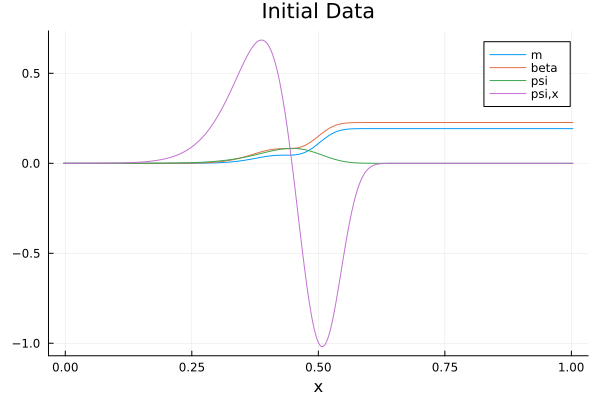

In [215]:
using Plots #showing initial data and the initial status of the horizon finder
plot(R, state_array, xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[0.4, 1])

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [216]:
using CSV, Tables
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

 ## Time evolution

In [217]:
using Interpolations
using ProgressMeter
@showprogress for k in 1:length(T)

    #evolve psi,x
    state_array=rungekutta4molstep(SF_RHS,state_array,T,k,0) #evolve psi,x
    state_array=ghost(state_array)
    
    #calculate psi from psi,x
   " interp = cubic_spline_interpolation(R[4:L-3], state_array[4:L-3,4],  extrapolation_bc = Line())

    psi0=0
    SFconstraint_psi_new(psi0,R1) = interp.(R1)

    state_array[:,3] = rungekutta4(SFconstraint_psi_new,psi0,R)
    state_array=ghost(state_array)"
    
    #calculate psi form psi,x
    spl = scipyinterpolate.splrep(R[4:L-3], state_array[4:L-3,4],k=5)
    psi0=0
    SFconstraint_psi_new(psi0,R) = scipyinterpolate.splev(R, spl)
    state_array[4:L-3,3] = rungekutta4(SFconstraint_psi_new,psi0,R1)
    state_array=ghost(state_array);
    
    #evolve m
    m0=0
    state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,R1,T)
    
    state_array=ghost(state_array)
    
    #evolve beta
    beta0=0
    state_array[4:L-3,2]=rungekutta4(SFconstraint_beta,beta0,R1)
    
    state_array=ghost(state_array)
    
    CSV.write(dir*"/time_step$k.csv", Tables.table(state_array), writeheader=false)
end

Progress:  83%|██████████████████████████████████       |  ETA: 0:02:46

LoadError: InterruptException:

In [218]:
#monitor_ratio = 1-v/rexp(-2beta)
monitor_ratio = zeros(L)
for i in 1:L
    monitor_ratio = 2*state_array[:,1]/R[i]*(1-R[i])
    if monitor_ratio[i]>0.6
        print("hey BH")
    end
end

In [177]:
print(monitor_ratio)

[NaN, NaN, NaN, -0.0, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN

In [178]:
print(dir)

/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1

## Movie of the evolution

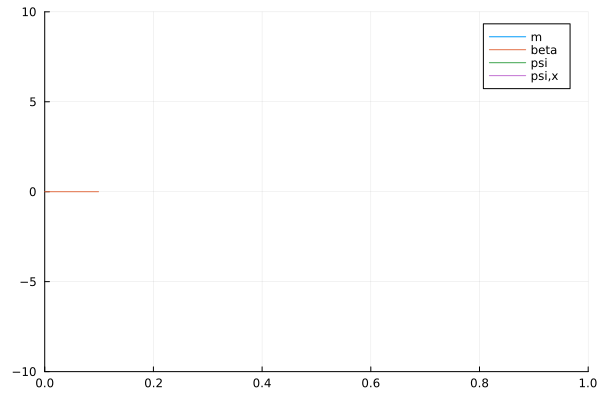

┌ Info: Saved animation to 
│   fn = /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif
└ @ Plots /home/rita13santos/.julia/packages/Plots/fw4rv/src/animation.jl:156


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
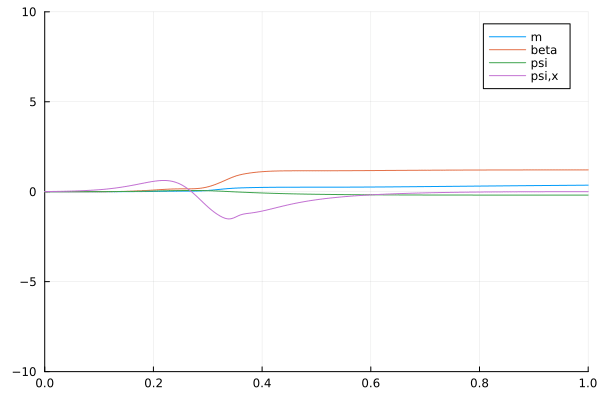

In [225]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 800:1:900#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(R1, [plot1 plot2 plot3 plot4], labels=["m" "beta" "psi" "psi,x"],ylim=[-10, 10],xlim=[0,1]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 15)